# Практическая работа №6: Кластерный анализ. Метод k-средних

Выполнил студент гр. 1384 Шаганов Вячеслав.

## Цель работы

Освоение основных понятий и некоторых методов кластерного анализа, в частности, метода k-средних.

## Основные теоретические положения

1. Метод k-средних

    Метод k-средних стремится минимизировать сумму квадратов расстояний от каждой точки до центроида её кластера. Формально, задача заключается в минимизации функционала:

    $ F_1 = \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2 $
    где:

    $k$ — количество кластеров,
    $C_i$ — множество точек, принадлежащих $i$-му кластеру,
    $μ_i$ — центроид $i$-го кластера,
    $x$ — точка данных.
    Алгоритм работает следующим образом:

    Инициализация: случайным образом выбираются 
    $k$ центроидов.
    Назначение кластеров: каждая точка назначается ближайшему центроиду.
    Пересчет центроидов: центроиды обновляются как среднее значение всех точек, назначенных соответствующему кластеру.
    Повторение шагов 2 и 3 до сходимости (когда центроиды перестают изменяться).

2. Функционалы качества кластеризации

    Для оценки качества разбиения используются следующие функционалы:

    $F_1$ — сумма квадратов расстояний от точек до центроидов их кластеров:

    - $ F_1 = \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2 $
    
    $F_2$ — сумма внутрикластерных расстояний между точками:
    
    - $ F_2 = \sum_{i=1}^{k} \sum_{x, y \in C_i} \|x - y\| $

    $F_3$ — сумма внутрикластерных дисперсий:
    
    - $ F_3 = \sum_{i=1}^{k} \text{Var}(C_i) $
    
    где 
    $Var(C_i)$ — дисперсия точек в $i$-м кластере относительно его центроида.

3. Нормализация данных

    Для корректной работы алгоритма данные часто нормализуются, чтобы привести все признаки к одному масштабу. В данной работе используется следующая нормализация:

    $ x_{\text{norm}} = \frac{x - \bar{x}}{S_x} $



## Постановка задачи

Дано конечное множество из объектов, представленных двумя признаками (в качестве этого множества принимаем исходную двумерную выборку, сформированную ранее в практической работе №4). Выполнить разбиение исходного множества объектов на конечное число подмножеств (кластеров) с использованием метода k-means. Полученные результаты содержательно проинтерпретировать.

## Выполнение работы

Загрузим выборку:

In [35]:
import numpy as np
import matplotlib.pyplot as plt

with open('sample.txt', 'r') as f:
    sample = [[float(e) for e in s.split()] for s in f.readlines()]
print("Размер выборки:", len(sample))

sample = np.array(sample)

data = sample.copy()

Размер выборки: 120


#### Задание 1. Нормализовать множество точек из предыдущего раздела, отобразить полученное множество.

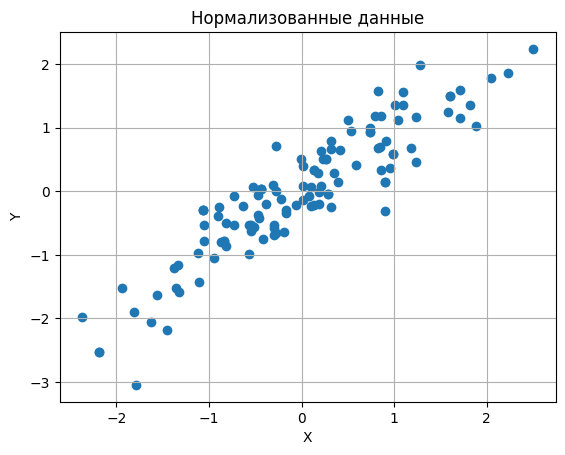

In [98]:
def normalize_data(data):
    return (data - data.mean(axis=0)) / data.std(axis=0)

data_normalized = normalize_data(data)

# Отображение нормализованных данных
plt.grid()
plt.scatter(data_normalized[:, 0], data_normalized[:, 1])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Нормализованные данные")
plt.show()

#### Задание 2. Определить грубую верхнюю оценку количества кластеров: $ \tilde k = \lfloor\sqrt{N/2}\rfloor $, где $ N $ -- число точек.

In [38]:
k_estimate = int(np.floor(np.sqrt(len(data) / 2)))
print(f"Грубая верхняя оценка количества кластеров: {k_estimate}")

Грубая верхняя оценка количества кластеров: 7


#### Задание 3. Реализовать алгоритм k-means в двух вариантах: 
- пересчет центра кластера осуществляется после каждого изменения его состава;
- пересчет центра кластера осуществляется лишь после того, как будет завершен просмотр всех данных (шаг процедуры).

In [63]:
def kmeans_v1(data, k, max_iter=100, callbacks=[]):
    # Random centroids
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    
    for _ in range(max_iter):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
        [callback(labels, centroids) for callback in callbacks]
    
    return labels, centroids

def kmeans_v2(data, k, max_iter=100, callbacks=[]):
    # Random centroids
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    
    for _ in range(max_iter):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
        [callback(labels, centroids) for callback in callbacks]
    
    return labels, centroids

#### Задание 4. - На каждом шаге процедуры разбиения методом k-means вычислять функционалы качества полученного разбиения:
- $ F_1 $ -- сумма по всем кластерам квадратов расстояний элементов кластеров до центров соответствующих кластеров;
- $ F_2 $ -- сумма по всем кластерам внутрикластерных расстояний между элементами кластеров;
- $ F_3 $ -- сумма по всем кластерам внутрикластерных дисперсий (относительно центров кластеров).

In [64]:
class Score: 
    def __init__(self, fn):
        self.fn = fn
        self.data = []
    
    def __call__(self, *args):
        val = self.fn(*args)
        self.data.append(val)
        return val

def generate_F1(data):
    F1 = lambda labels, centroids: np.sum([np.sum((data[labels == i] - centroids[i])**2) for i in range(len(centroids))])
    return Score(F1)

def generate_F2(data):
    F2 = lambda labels, centroids: np.sum([np.sum(np.linalg.norm(data[labels == i][:, np.newaxis] - data[labels == i], axis=2)) for i in np.unique(labels)])
    return Score(F2)

def generate_F3(data):
    F3 = lambda labels, centroids: np.sum([np.var(data[labels == i], axis=0).sum() for i in range(len(centroids))])
    return Score(F3)

In [93]:
# Вычисление функционалов качества для первого варианта
F1_v1 = generate_F1(data_normalized)
F2_v1 = generate_F2(data_normalized)
F3_v1 = generate_F3(data_normalized)

labels_v1, centroids_v1 = kmeans_v1(data_normalized, k_estimate, callbacks=[F1_v1, F2_v1, F3_v1])

# Вычисление функционалов качества для второго варианта
F1_v2 = generate_F1(data_normalized)
F2_v2 = generate_F2(data_normalized)
F3_v2 = generate_F3(data_normalized)

labels_v2, centroids_v2 = kmeans_v2(data_normalized, k_estimate, callbacks=[F1_v2, F2_v2, F3_v2])

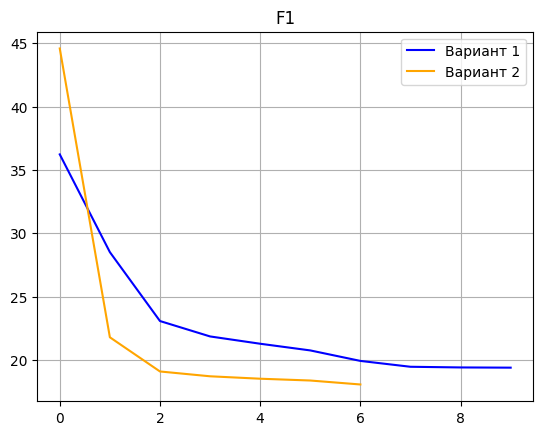

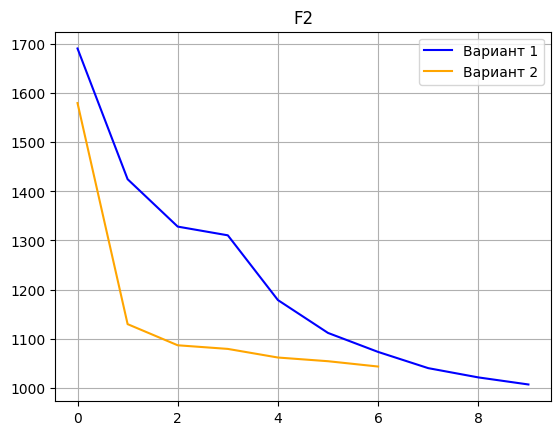

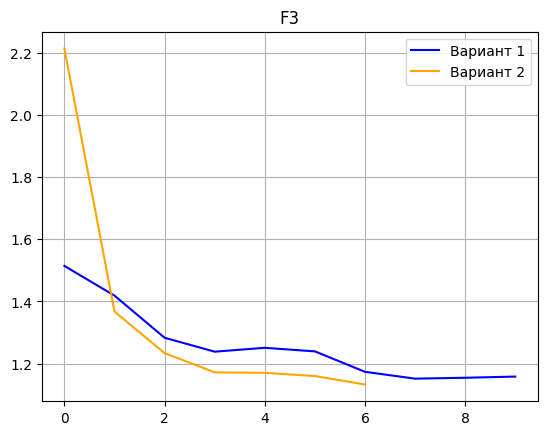

In [94]:
def draw_scores(v1, v2, label):
    plt.grid()
    plt.title(label)
    plt.plot(v1, c='b', label="Вариант 1")
    plt.plot(v2, c='orange', label="Вариант 2")
    plt.legend()
    plt.show()

draw_scores(F1_v1.data, F1_v2.data, 'F1')
draw_scores(F2_v1.data, F2_v2.data, 'F2')
draw_scores(F3_v1.data, F3_v2.data, 'F3')

#### Задание 5. Отобразить полученные кластеры, выделить каждый кластер разным цветом, отметить центроиды.

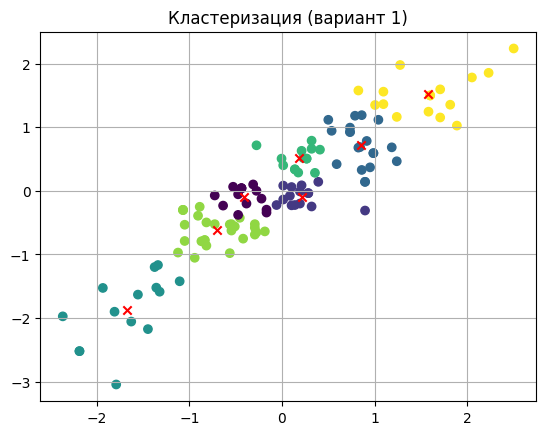

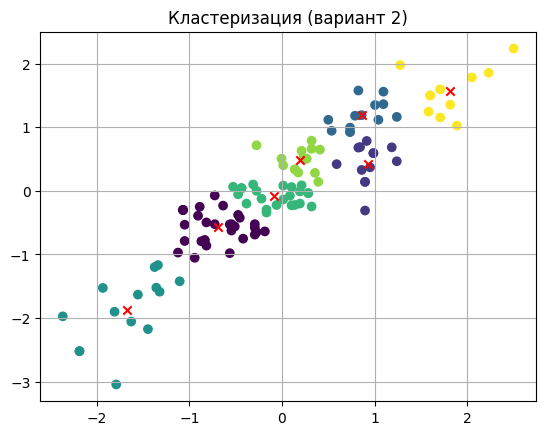

In [96]:

# Визуализация результатов первого варианта
plt.scatter(data_normalized[:, 0], data_normalized[:, 1], c=labels_v1, cmap='viridis')
plt.scatter(centroids_v1[:, 0], centroids_v1[:, 1], c='red', marker='x')
plt.title("Кластеризация (вариант 1)")
plt.grid()
plt.show()

# Визуализация результатов второго варианта
plt.scatter(data_normalized[:, 0], data_normalized[:, 1], c=labels_v2, cmap='viridis')
plt.scatter(centroids_v2[:, 0], centroids_v2[:, 1], c='red', marker='x')
plt.title("Кластеризация (вариант 2)")
plt.grid()
plt.show()


#### Задание 6. Содержательно проинтерпретировать полученные результаты.

Метод k-means успешно минимизирует внутрикластерные расстояния, что подтверждается плавным снижением функционалов $F_1$, $F_2$ и $F_3$, на каждом шаге. Оба варианта алгоритма — с пересчетом центроидов после каждого изменения и после завершения просмотра всех данных — дают схожие результаты, что говорит об их устойчивости. Кластеры представляют собой группы близких точек, а центроиды — их "типичных представителей". Однако выбранное количество кластеров (k=7) кажется избыточным, так как данные визуально напоминают нормальное распределение без явно выраженных групп. Это может привести к искусственному разделению данных на слишком мелкие кластеры, что затрудняет их содержательную интерпретацию. Для улучшения результатов стоит уменьшить количество кластеров или использовать методы, такие как метод локтя или метод силуэтов, чтобы определить более подходящее значение k.

## Выводы

В ходе выполнения практической работы был реализован метод k-средних (k-means) для кластеризации данных. Использовались два варианта алгоритма: с пересчетом центроидов после каждого изменения и после завершения просмотра всех данных. Для оценки качества кластеризации были вычислены функционалы $F_1$, $F_2$ и $F_3$, которые характеризуют компактность и однородность кластеров.